### Loading the modules and data

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Sundar_Notebooks")
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
BasicCNN.ipynb			   existingmodel.py	   X_test.npy
BasicCNN-Keerthana.ipynb	   model		   X_train_valid.npy
BasicCNN_varshinee.ipynb	   person_test.npy	   y_test.npy
BasicCNN_Vikranth-Keerthana.ipynb  person_train_valid.npy  y_train_valid.npy
best_model			   __pycache__
CNN-checkpoint.ipynb		   RNN_Sundar.ipynb


In [0]:
%load_ext autoreload
%autoreload 2
#from existingmodel import *

In [0]:
import sys
import os
import time
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, TimeDistributed, Conv2D, MaxPooling2D, Bidirectional, LSTM
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Permute, Reshape
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import itertools

Using TensorFlow backend.


In [0]:
import numpy as np

from __future__ import print_function
from keras.utils.vis_utils import plot_model

import keras
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D
from keras.layers import RNN, LSTM, Bidirectional
from keras.models import Sequential

import matplotlib.pylab as plt



#### Data loading and preperation

The following two cells load the data and prepare it to be suitable for input to neural network models. Run them only once.

In [0]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train = np.load("person_train_valid.npy")
X_train = np.load("X_train_valid.npy")
y_train = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [0]:
### Swapping axes for inputs.
###  Reason is that we need the number of channels as 25

X_train = np.swapaxes(X_train,1,2)
X_test = np.swapaxes(X_test,1,2)

#### y labels are in the range 769 to 772, wrapping them back to 0 - 3
y_train -= 769
y_test -= 769

num_classes = 4
#### massaging y labels to suit to input to our ML model

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


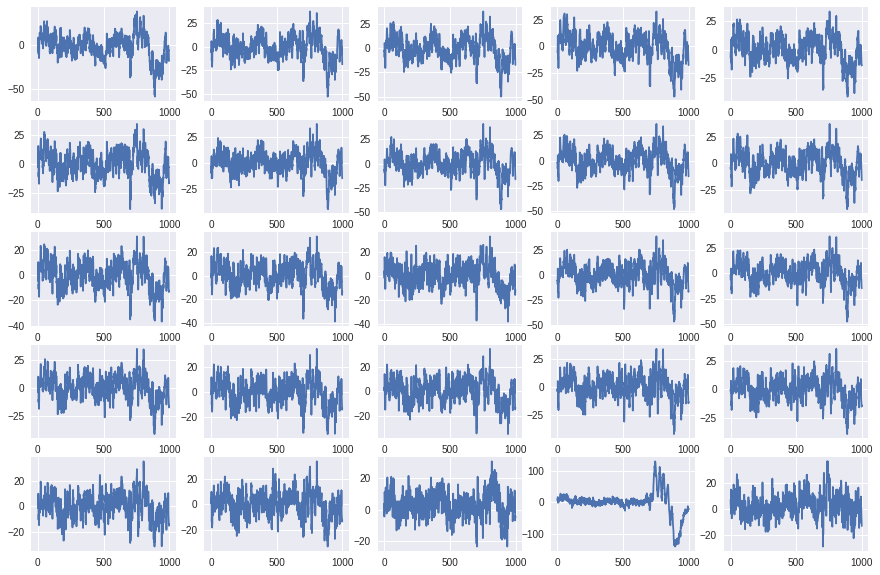

In [0]:
f, ax = plt.subplots(5,5,figsize=(15,10))

for i in np.arange(25):
    idx = i%5
    idy = i//5
    ax[idy,idx].plot(X_train[45,:,i])
plt.show()

### Feature extraction 
I am using a simple wavelet decomposition here, but more complicated techniques could be used.

In [0]:
#import pywt

num_signals = 25 ### 25 if using EOG, 22 otherwise
feat_extract = False

if feat_extract:
    mother = 'db4'
    levels = 3
    mode = 'zero'
    feats_train = pywt.wavedec(X_train,mother,axis = 1, level = levels, mode = mode)
    feats_train = np.concatenate(feats_train,axis = 1)
    feats_test = pywt.wavedec(X_test,mother,axis = 1, level = levels, mode = mode)
    feats_test = np.concatenate(feats_test,axis = 1)
else:
    feats_train = X_train
    feats_test = X_test

feats_train = feats_train[:,:,0:num_signals]
feats_test = feats_test[:,:,0:num_signals]

#### Feature scaling

In [0]:
feat_scale = 'on' ####making features 0 mean and unit variance

if feat_scale == 'on':
   temp = feats_train - feats_train.mean(axis=(0))
   temp = temp/feats_train.std(axis=(0))
   feats_train = temp
   temp = feats_test - feats_test.mean(axis=(0))
   temp = temp/feats_test.std(axis=(0))
   feats_test = temp

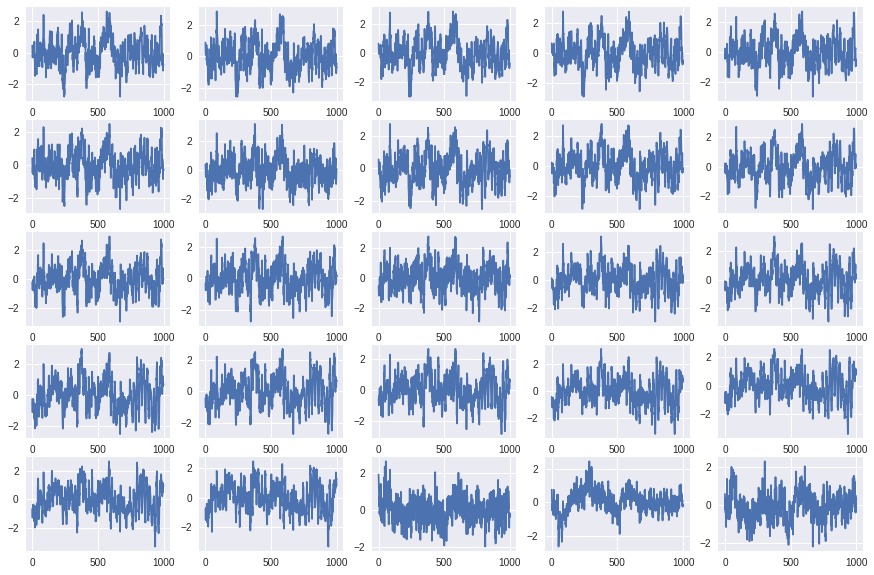

In [0]:
f, ax = plt.subplots(5,5,figsize=(15,10))

for i in np.arange(25):
    idx = i%5
    idy = i//5
    ax[idy,idx].plot(feats_train[0,:,i])
plt.show()

### Shape of data

In [0]:
print ('Training/Valid data shape: {}'.format(feats_train.shape))
print ('Test data shape: {}'.format(feats_test.shape))
print ('Training/Valid target shape: {}'.format(y_train.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 1000, 25)
Test data shape: (443, 1000, 25)
Training/Valid target shape: (2115, 4)
Test target shape: (443, 4)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


#### Setting some constants for classification

In [0]:
num_classes = 4
N, W, C = feats_train.shape

In [0]:

def model_CNN_3(dim, win_len, num_classes, num_feat_map=64, p=0.5):
  model = Sequential()
  model.add(Conv2D(64, kernel_size=(1, 5),
                   activation='relu',
                   input_shape=(dim, win_len, 1),
                   padding='same', name='Conv_1'))
  model.add(MaxPooling2D(pool_size=(1, 2), name='Max_pool_1'))
  model.add(BatchNormalization(name='Bn_1'))
  model.add(Dropout(p, name='Drop_1'))
  model.add(Conv2D(128, kernel_size=(1, 5), activation='relu', padding='same', name='Conv_2'))
  model.add(MaxPooling2D(pool_size=(1, 2), name='Max_pool_2'))
  model.add(BatchNormalization(name='Bn_2'))
  model.add(Dropout(p, name='Drop_2'))
  model.add(Conv2D(128, kernel_size=(1, 5), activation='relu', padding='same', name='Conv_3'))
  model.add(BatchNormalization(name='Bn_3'))
 # model.add(MaxPooling2D(pool_size=(1, 2), name='Max_pool_3'))
  model.add(Dropout(p, name='Drop_3'))
  model.add(Conv2D(64, kernel_size=(1, 3), activation='relu', padding='same', name='Conv_4'))
  model.add(BatchNormalization(name='Bn_4'))
  #model.add(MaxPooling2D(pool_size=(1, 2), name='Max_pool_4'))
  model.add(Dropout(p, name='Drop_4'))
  model.add(Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same', name='Conv_5'))
  model.add(BatchNormalization(name='Bn_5'))
  #model.add(MaxPooling2D(pool_size=(1, 2), name='Max_pool_5'))
  model.add(Dropout(p, name='Drop_5'))
  model.add(Conv2D(16, kernel_size=(1, 3), activation='relu', padding='same', name='Conv_6'))
  model.add(BatchNormalization(name='Bn_6'))
  #model.add(MaxPooling2D(pool_size=(1, 2), name='Max_pool_6'))
  model.add(Dropout(p, name='Drop_6'))
  model.add(Permute((2, 1, 3), name='Permute_1'))  # for swap-dimension
  model.add(Reshape((-1, num_feat_map * dim), name='Reshape_1'))
  model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', name='Conv_7'))
  model.add(BatchNormalization(name='Bn_7'))
  model.add(Dropout(p, name='Drop_7'))
  model.add(LSTM(128, return_sequences=True, stateful=False, name='Lstm_1'))
  model.add(BatchNormalization(name='Bn_8'))
  #model.add(MaxPooling2D(pool_size=(1, 2), name='Max_pool_6'))
  model.add(Dropout(p, name='Drop_8'))
  #model.add(LSTM(128, return_sequences=True, stateful=False, name='Lstm_2'))
  #model.add(BatchNormalization(name='Bn_9'))
  model.add(Flatten(name='Flatten_1'))
  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization(name='Bn_10'))
  model.add(Dropout(p, name='Drop_9'))
  model.add(Dense(num_classes, activation='softmax', name='dense_out'))
  return model

In [0]:
model3 = model_CNN_3(C, W, num_classes, num_feat_map=32, p=0.5)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 25, 1000, 64)      384       
_________________________________________________________________
Max_pool_1 (MaxPooling2D)    (None, 25, 500, 64)       0         
_________________________________________________________________
Bn_1 (BatchNormalization)    (None, 25, 500, 64)       256       
_________________________________________________________________
Drop_1 (Dropout)             (None, 25, 500, 64)       0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 25, 500, 128)      41088     
_________________________________________________________________
Max_pool_2 (MaxPooling2D)    (None, 25, 250, 128)      0         
_________________________________________________________________
Bn_2 (BatchNormalization)    (None, 25, 250, 128)      512       
__________

In [0]:
model3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# class AccuracyHistory(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.acc = []

#     def on_epoch_end(self, batch, logs={}):
#         self.acc.append(logs.get('acc'))

# history = AccuracyHistory()

#### Setting some hyperparameters for the architecture

#### Definining the sequential model

The following cell defines the sequential model we will run. We will play around with different architectures and layers and log the error rates for each of these.

In [0]:
def reshape_data(X_tr, X_tst):
    _, win_len, dim = X_tr.shape
    # make it into (frame_number, dimension, window_size, channel=1) for convNet
    X_tr = np.swapaxes(X_tr, 1, 2)
    X_tst = np.swapaxes(X_tst, 1, 2)

    X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
    X_tst = np.reshape(X_tst, (-1, dim, win_len, 1))

    return X_tr, X_tst

In [0]:
feats_train, feats_test = reshape_data(feats_train, feats_test)
print(feats_train.shape)
print(feats_test.shape)

ValueError: ignored

#### Training and performance evaluation for the model above

In [0]:
checkpoint = ModelCheckpoint('best_model', monitor = 'val_acc', verbose =1, save_best_only = True, mode ='max')
callbacks_list = [checkpoint]


In [0]:
#### Hyperparameters for SGD####
epochs = 20
batch_size = 50


import time
start = time.time()
##### Training ######
model, H = model3.fit(feats_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.1,
          callbacks=callbacks_list, shuffle = True)

#Save the final model
model.save('final_model')



Train on 1903 samples, validate on 212 samples
Epoch 1/20
1903/1903 [==============================] - 31s 16ms/step - loss: 0.6076 - acc: 0.7683 - val_loss: 0.8658 - val_acc: 0.7028

Epoch 00001: val_acc did not improve from 0.71698
Epoch 2/20
1903/1903 [==============================] - 31s 16ms/step - loss: 0.6541 - acc: 0.7467 - val_loss: 0.8082 - val_acc: 0.6934

Epoch 00002: val_acc did not improve from 0.71698
Epoch 3/20
1903/1903 [==============================] - 31s 16ms/step - loss: 0.5717 - acc: 0.7693 - val_loss: 0.7927 - val_acc: 0.7170

Epoch 00003: val_acc did not improve from 0.71698
Epoch 4/20
1903/1903 [==============================] - 31s 16ms/step - loss: 0.5380 - acc: 0.7951 - val_loss: 0.7636 - val_acc: 0.7123

Epoch 00004: val_acc did not improve from 0.71698
Epoch 5/20
1903/1903 [==============================] - 31s 16ms/step - loss: 0.5030 - acc: 0.8029 - val_loss: 0.7650 - val_acc: 0.7075

Epoch 00005: val_acc did not improve from 0.71698
Epoch 6/20
1903/19

TypeError: ignored

In [0]:
#Load Trained Model
model = load_model('best_model')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 25, 1000, 64)      384       
_________________________________________________________________
Max_pool_1 (MaxPooling2D)    (None, 25, 500, 64)       0         
_________________________________________________________________
Bn_1 (BatchNormalization)    (None, 25, 500, 64)       256       
_________________________________________________________________
Drop_1 (Dropout)             (None, 25, 500, 64)       0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 25, 500, 128)      41088     
_________________________________________________________________
Max_pool_2 (MaxPooling2D)    (None, 25, 250, 128)      0         
_________________________________________________________________
Bn_2 (BatchNormalization)    (None, 25, 250, 128)      512       
__________

Text(0.5, 0, 'Predicted label')

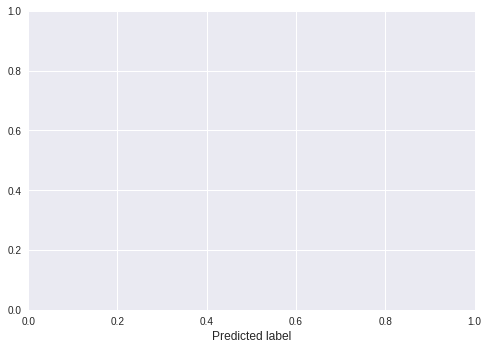

In [0]:
def calculate_metrics(model, X_test, y_test_binary):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test_binary, axis=1)
    mismatch = np.where(y_true != y_pred)
    cf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    #micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return cf_matrix, accuracy, macro_f1, mismatch, y_pred


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        print(cm)
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.figure(figsize = (10,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 15)
    plt.yticks(tick_marks, classes, fontsize = 15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label', fontsize = 12)
plt.xlabel('Predicted label', fontsize = 12)

In [0]:
##### Testing #####
score = model.evaluate(feats_test, y_test, verbose=0)

end = time.time()

print('Time taken to train: {} minutes'.format((end-start)//60))

print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs+1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Time taken to train: 10.0 minutes
Test loss: 0.8277208608644542
Test accuracy: 0.6794582410267729


NameError: ignored

In [0]:
#### Hyperparameters for SGD####
epochs = 4
batch_size = 100

import time
start = time.time()
##### Training ######
model.fit(feats_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.1,
          callbacks=[history], shuffle = True)


##### Testing #####
score = model.evaluate(feats_test, y_test, verbose=0)

end = time.time()

print('Time taken to train: {} minutes'.format((end-start)//60))

print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs+1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

NameError: ignored

In [0]:
plot_model(model3, show_shapes=True,to_file='model1.png')